# Training and Hosting a PyTorch model in Amazon SageMaker

*(This notebook was tested with the "Python 3 (PyTorch CPU Optimized)" kernel.)*

Amazon SageMaker is a fully managed service that provides developers and data scientists with the ability to build, train, and deploy machine learning (ML) models quickly. Amazon SageMaker removes the heavy lifting from each step of the machine learning process to make it easier to develop high-quality models. The SageMaker Python SDK makes it easy to train and deploy models in Amazon SageMaker with several different machine learning and deep learning frameworks, including PyTorch.

In this notebook, we use Amazon SageMaker to train a convolutional neural network using PyTorch and the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html), and then we host the model in Amazon SageMaker for inference.

## Setup

Let's start by specifying:

- An Amazon S3 bucket and prefix for training and model data. This should be in the same region used for SageMaker Studio, training, and hosting.
- An IAM role for SageMaker to access to your training and model data. If you wish to use a different role than the one set up for SageMaker Studio, replace `sagemaker.get_execution_role()` with the appropriate IAM role or ARN. For more about using IAM roles with SageMaker, see [the AWS documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-roles.html).

In [16]:
import sagemaker

sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
prefix = 'pytorch-cnn-cifar10-example'

role = sagemaker.get_execution_role()

Couldn't call 'get_role' to get Role ARN from role name AmazonSageMaker-ExecutionRole-20210219T110928 to get Role path.
Assuming role was created in SageMaker AWS console, as the name contains `AmazonSageMaker-ExecutionRole`. Defaulting to Role ARN with service-role in path. If this Role ARN is incorrect, please add IAM read permissions to your role or supply the Role Arn directly.


## Prepare the training data

The [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) is a subset of the [80 million tiny images dataset](https://people.csail.mit.edu/torralba/tinyimages). It consists of 60,000 32x32 color images in 10 classes, with 6,000 images per class.

### Download the data

First we download the dataset:

In [3]:
%%bash

wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz --quiet
tar xfvz cifar-10-python.tar.gz

mkdir data
mv cifar-10-batches-py data/.

rm cifar-10-python.tar.gz

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


tar: cifar-10-batches-py/data_batch_4: Cannot change ownership to uid 2156, gid 1103: Operation not permitted
tar: cifar-10-batches-py/readme.html: Cannot change ownership to uid 2156, gid 1103: Operation not permitted
tar: cifar-10-batches-py/test_batch: Cannot change ownership to uid 2156, gid 1103: Operation not permitted
tar: cifar-10-batches-py/data_batch_3: Cannot change ownership to uid 2156, gid 1103: Operation not permitted
tar: cifar-10-batches-py/batches.meta: Cannot change ownership to uid 2156, gid 1103: Operation not permitted
tar: cifar-10-batches-py/data_batch_2: Cannot change ownership to uid 2156, gid 1103: Operation not permitted
tar: cifar-10-batches-py/data_batch_5: Cannot change ownership to uid 2156, gid 1103: Operation not permitted
tar: cifar-10-batches-py/data_batch_1: Cannot change ownership to uid 2156, gid 1103: Operation not permitted
tar: cifar-10-batches-py: Cannot change ownership to uid 2156, gid 1103: Operation not permitted
tar: Exiting with failure 

In [4]:
from urllib import request
request.urlretrieve('https://raw.githubusercontent.com/aws/amazon-sagemaker-examples/master/aws_sagemaker_studio/frameworks/pytorch_cnn_cifar10/cifar_utils.py', 'cifar_utils.py')
request.urlretrieve('https://raw.githubusercontent.com/aws/amazon-sagemaker-examples/master/aws_sagemaker_studio/frameworks/pytorch_cnn_cifar10/source/cifar10.py', 'cifar10.py')
print("Done Downloading Assets")

Done Downloading Assets


After downloading the dataset, we use the [`torchvision.datasets` module](https://pytorch.org/docs/stable/torchvision/datasets.html) to load the CIFAR-10 dataset, utilizing the [`torchvision.transforms` module](https://pytorch.org/docs/stable/torchvision/transforms.html) to convert the data into normalized tensor images:

In [5]:
from cifar_utils import classes, show_img, train_data_loader, test_data_loader

train_loader = train_data_loader()
test_loader = test_data_loader()

### Preview the data

Now we can view some of data we have prepared:

      dog       car     truck      frog


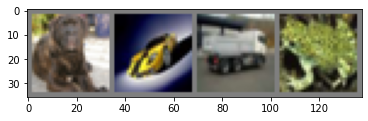

In [6]:
import numpy as np
import torchvision, torch

# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
show_img(torchvision.utils.make_grid(images))

# print labels
print(' '.join('%9s' % classes[labels[j]] for j in range(4)))

### Upload the data
We use the `sagemaker.s3.S3Uploader` to upload our dataset to Amazon S3. The return value `inputs` identifies the location -- we use this later for the training job.

In [14]:
from sagemaker.s3 import S3Uploader

inputs = S3Uploader.upload('data', 's3://{}/{}/data'.format(bucket, prefix))

## Prepare the entry-point script

When SageMaker trains and hosts our model, it runs a Python script that we provide. (This is run as the entry point of a Docker container.) For training, this script contains the PyTorch code needed for the model to learn from our dataset. For inference, the code is for loading the model and processing the prediction input. For convenience, we put both the training and inference code in the same file.

### Training

The training code is very similar to a training script we might run outside of Amazon SageMaker, but we can access useful properties about the training environment through various environment variables. For this notebook, our script retrieves the following environment variable values:

* `SM_HOSTS`: a list of hosts on the container network.
* `SM_CURRENT_HOST`: the name of the current container on the container network.
* `SM_MODEL_DIR`: the location for model artifacts. This directory is uploaded to Amazon S3 at the end of the training job.
* `SM_CHANNEL_TRAINING`: the location of our training data.
* `SM_NUM_GPUS`: the number of GPUs available to the current container.

We also use a main guard (`if __name__=='__main__':`) to ensure that our training code is executed only for training, as SageMaker imports the entry-point script.

For more about writing a PyTorch training script with SageMaker, please see the [SageMaker documentation](https://sagemaker.readthedocs.io/en/stable/using_pytorch.html#prepare-a-pytorch-training-script).

### Inference

For inference, we need to implement a few specific functions to tell SageMaker how to load our model and handle prediction input.

* `model_fn(model_dir)`: loads the model from disk. This function must be implemented.
* `input_fn(serialized_input_data, content_type)`: deserializes the prediction input.
* `predict_fn(input_data, model)`: calls the model on the deserialized data.
* `output_fn(prediction_output, accept)`: serializes the prediction output.

The last three functions - `input_fn`, `predict_fn`, and `output_fn` - are optional because SageMaker has default implementations to handle common content types. However, there is no default implementation of `model_fn` for PyTorch models on SageMaker, so our script has to implement `model_fn`.

For more about PyTorch inference with SageMaker, please see the [SageMaker documentation](https://sagemaker.readthedocs.io/en/stable/using_pytorch.html#id3).

### Put it all together

Here is the full script for both training and hosting our convolutional neural network:

In [8]:
!pygmentize ./cifar10.py

# Copyright 2020 Amazon.com, Inc. or its affiliates. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License"). You
# may not use this file except in compliance with the License. A copy of
# the License is located at
#
#     http://aws.amazon.com/apache2.0/
#
# or in the "license" file accompanying this file. This file is
# distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF
# ANY KIND, either express or implied. See the License for the specific
# language governing permissions and limitations under the License.
import argparse
import json
import logging
import os

import torch
import torch.distributed as dist
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
import torch.optim
import torch.utils.data
import torch.utils.data.distributed
import torchvision
import torchvision.models
import torchvision.transforms as transforms

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)

classes = ('plane'

## Run a SageMaker training job

The SageMaker Python SDK makes it easy for us to interact with SageMaker. Here, we use the `PyTorch` estimator class to start a training job. We configure it with the following parameters:

* `entry_point`: our training script.
* `role`: an IAM role that SageMaker uses to access training and model data.
* `framework_version`: the PyTorch version we wish to use. For a list of supported versions, see [here](https://github.com/aws/sagemaker-python-sdk#pytorch-sagemaker-estimators).
* `train_instance_count`: the number of training instances.
* `train_instance_type`: the training instance type. For a list of supported instance types, see [the AWS Documentation](https://aws.amazon.com/sagemaker/pricing/instance-types/).

Once we our `PyTorch` estimator, we start a training job by calling `fit()` and passing the training data we uploaded to S3 earlier.

In [15]:
from sagemaker.pytorch import PyTorch

estimator = PyTorch(entry_point='./cifar10.py',
                    role=role,
                    framework_version='1.4.0',
                    train_instance_count=1,
                    train_instance_type='ml.g4dn.xlarge')

estimator.fit(inputs)

ValueError: framework_version or py_version was None, yet image_uri was also None. Either specify both framework_version and py_version, or specify image_uri.

## Deploy the model for inference

After we train our model, we can deploy it to a SageMaker Endpoint, which serves prediction requests in real-time. To do so, we simply call `deploy()` on our estimator, passing in the desired number of instances and instance type for the endpoint:

In [ ]:
predictor = estimator.deploy(initial_instance_count=1, instance_type='ml.c5.xlarge')

### Invoke the endpoint

We then use the returned `predictor` object to invoke our endpoint. For demonstration purposes, we also print out the image, its original label, and its predicted label.

In [ ]:
# get some test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# print images, labels, and predictions
show_img(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%4s' % classes[labels[j]] for j in range(4)))

outputs = predictor.predict(images.numpy())

_, predicted = torch.max(torch.from_numpy(np.array(outputs)), 1)

print('Predicted:   ', ' '.join('%4s' % classes[predicted[j]] for j in range(4)))

## Cleanup

Once finished, we delete our endpoint to release the instances (and avoid incurring extra costs).

In [ ]:
predictor.delete_endpoint()